In [15]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    try:
        os.chdir(os.path.abspath(os.path.join(os.path.abspath(os.path.dirname(__vsc_ipynb_file__)), os.pardir)))
        print("Working on local machine...")
    except:
        print("Can't change directory. Quitting...")
        exit(1)

Working on local machine...


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import ta  # Technical Analysis library for financial data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from livelossplot import PlotLosses


import glob
import os


In [17]:
# Define the path to the folder containing the training and validation CSV files
import random


data_folder_path = './data/unprocessed/US/'

# Use glob to get all CSV files in the folder (for training and validation)
csv_files = glob.glob(data_folder_path + '*.txt')

print(f'Found {len(csv_files)} CSV files for training and validation.')

# Initialize an empty list to hold individual DataFrames
data_frames = []

csv_files = random.sample(csv_files, 20)

# Loop over all CSV files and read them into DataFrames
for file in csv_files:
    df = pd.read_csv(file, sep=',', header=0)
    df.drop(columns=['OpenInt'], inplace=True)
    data_frames.append(df)

# Concatenate all DataFrames into a single DataFrame for training and validation
combined_data = pd.concat(data_frames, ignore_index=True)

# Print a summary of the combined data
print(combined_data.info())


Found 7195 CSV files for training and validation.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9739 entries, 0 to 9738
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9739 non-null   object 
 1   Open    9739 non-null   float64
 2   High    9739 non-null   float64
 3   Low     9739 non-null   float64
 4   Close   9739 non-null   float64
 5   Volume  9739 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 456.6+ KB
None


In [18]:
# Load the S&P 500 CSV file for testing
sp500_data_path = './data/unprocessed/SPY.csv'  # Specify the correct path to your S&P 500 data file
sp500_data = pd.read_csv(sp500_data_path)
sp500_data.drop(columns=["Adj Close"], inplace=True)

# Print a summary of the S&P 500 data
print(sp500_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7939 entries, 0 to 7938
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7939 non-null   object 
 1   Open    7939 non-null   float64
 2   High    7939 non-null   float64
 3   Low     7939 non-null   float64
 4   Close   7939 non-null   float64
 5   Volume  7939 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 372.3+ KB
None


In [19]:
# Feature engineering function to apply to both datasets
def add_features(df):
    # Add basic technical indicators
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # # Relative Strength Index (RSI)
    # df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # # Moving Average Convergence Divergence (MACD)
    # macd = ta.trend.MACD(df['Close'])
    # df['MACD'] = macd.macd()
    # df['MACD_signal'] = macd.macd_signal()
    # df['MACD_diff'] = macd.macd_diff()

    # # Bollinger Bands
    # bollinger = ta.volatility.BollingerBands(df['Close'], window=20)
    # df['BB_high'] = bollinger.bollinger_hband()
    # df['BB_low'] = bollinger.bollinger_lband()
    # df['BB_width'] = bollinger.bollinger_wband()

    # # Stochastic Oscillator
    # stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    # df['Stoch_%K'] = stoch.stoch()
    # df['Stoch_%D'] = stoch.stoch_signal()

    # # Average True Range (ATR)
    # atr = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14)
    # df['ATR_14'] = atr.average_true_range()

    # # On-Balance Volume (OBV)
    # obv = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume'])
    # df['OBV'] = obv.on_balance_volume()

    # # Rolling statistics
    # df['Rolling_mean_5'] = df['Close'].rolling(window=5).mean()
    # df['Rolling_std_5'] = df['Close'].rolling(window=5).std()
    # df['Rolling_var_5'] = df['Close'].rolling(window=5).var()

    # # Lag features
    # df['Lag_1'] = df['Close'].shift(1)
    # df['Lag_2'] = df['Close'].shift(2)
    # df['Lag_3'] = df['Close'].shift(3)

    # # Daily Return
    # df['Daily_Return'] = df['Close'].pct_change()

    # # Cumulative Returns
    # df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()

    # # Price ratios
    # df['Close/Open'] = df['Close'] / df['Open']
    # df['High/Low'] = df['High'] / df['Low']

    # Drop NaN values created by rolling calculations
    df = df.dropna()
    return df

# Apply feature engineering to both datasets
combined_data = add_features(combined_data)
sp500_data = add_features(sp500_data)


In [20]:
# Update label creation: 1 for 'Long', 0 for 'Short'
combined_data['Label'] = np.where(combined_data['Close'].shift(-1) > combined_data['Close'], 1, 0)

# Apply the same labeling process for S&P 500 data
sp500_data['Label'] = np.where(sp500_data['Close'].shift(-1) > sp500_data['Close'], 1, 0)

# Drop NaN values created by the shift operation
combined_data = combined_data.dropna()
sp500_data = sp500_data.dropna()

# Select features and labels for training and validation
features = combined_data.drop(columns=['Label', 'Date'])  # Adjust if needed to drop non-feature columns
labels = combined_data['Label']

# Select features and labels for testing
features_test = sp500_data.drop(columns=['Label', 'Date'])  # Adjust if needed to drop non-feature columns
labels_test = sp500_data['Label']

In [21]:
# Split the combined data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)


In [22]:
# Initialize a scaler
scaler = StandardScaler()

# Fit and transform training data, transform validation and test data
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(features_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(labels_test.values, dtype=torch.long)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=63, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, lstm_hidden_dim, output_dim, dropout_prob=0.3):
        super(StockPredictor, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization after the second conv layer

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(lstm_hidden_dim * (input_dim // 2), hidden_dim1)  # Adjust input size based on pooling
        self.bn2 = nn.BatchNorm1d(hidden_dim1)  # Batch normalization for the first hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # Second hidden layer
        self.bn3 = nn.BatchNorm1d(hidden_dim2)  # Batch normalization for the second hidden layer
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  # Output layer

        self.relu = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer for regularization

    def forward(self, x):
        # Reshape input for convolutional layers (batch_size, channels, input_dim)
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, input_dim)

        # Convolutional layers with ReLU and Max Pooling
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.bn1(out)

        # Permute for LSTM input: (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)

        # LSTM layer
        out, _ = self.lstm(out)

        # Flatten the output from LSTM layers
        out = out.contiguous().view(out.size(0), -1)

        # Fully connected layers
        out = self.fc1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)  # Output layer
        return out

In [24]:
# Initialize the model
input_dim = X_train_tensor.shape[1]  # Number of input features
hidden_dim1 = 128  # Number of neurons in the first hidden layer
hidden_dim2 = 32   # Number of neurons in the second hidden layer
lstm_hidden_dim = 128  # Number of LSTM hidden units
output_dim = 2     # Binary output: Long, Short

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor(input_dim, hidden_dim1, hidden_dim2, lstm_hidden_dim, output_dim).to(device)

In [25]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize livelossplot for real-time plotting
liveloss = PlotLosses(outputs=['MatplotlibPlot'], groups={'Loss': ['loss', 'val_loss'], 'Accuracy': ['acc', 'val_acc'], 'Metrics': ['val_precision', 'val_recall', 'val_f1']})


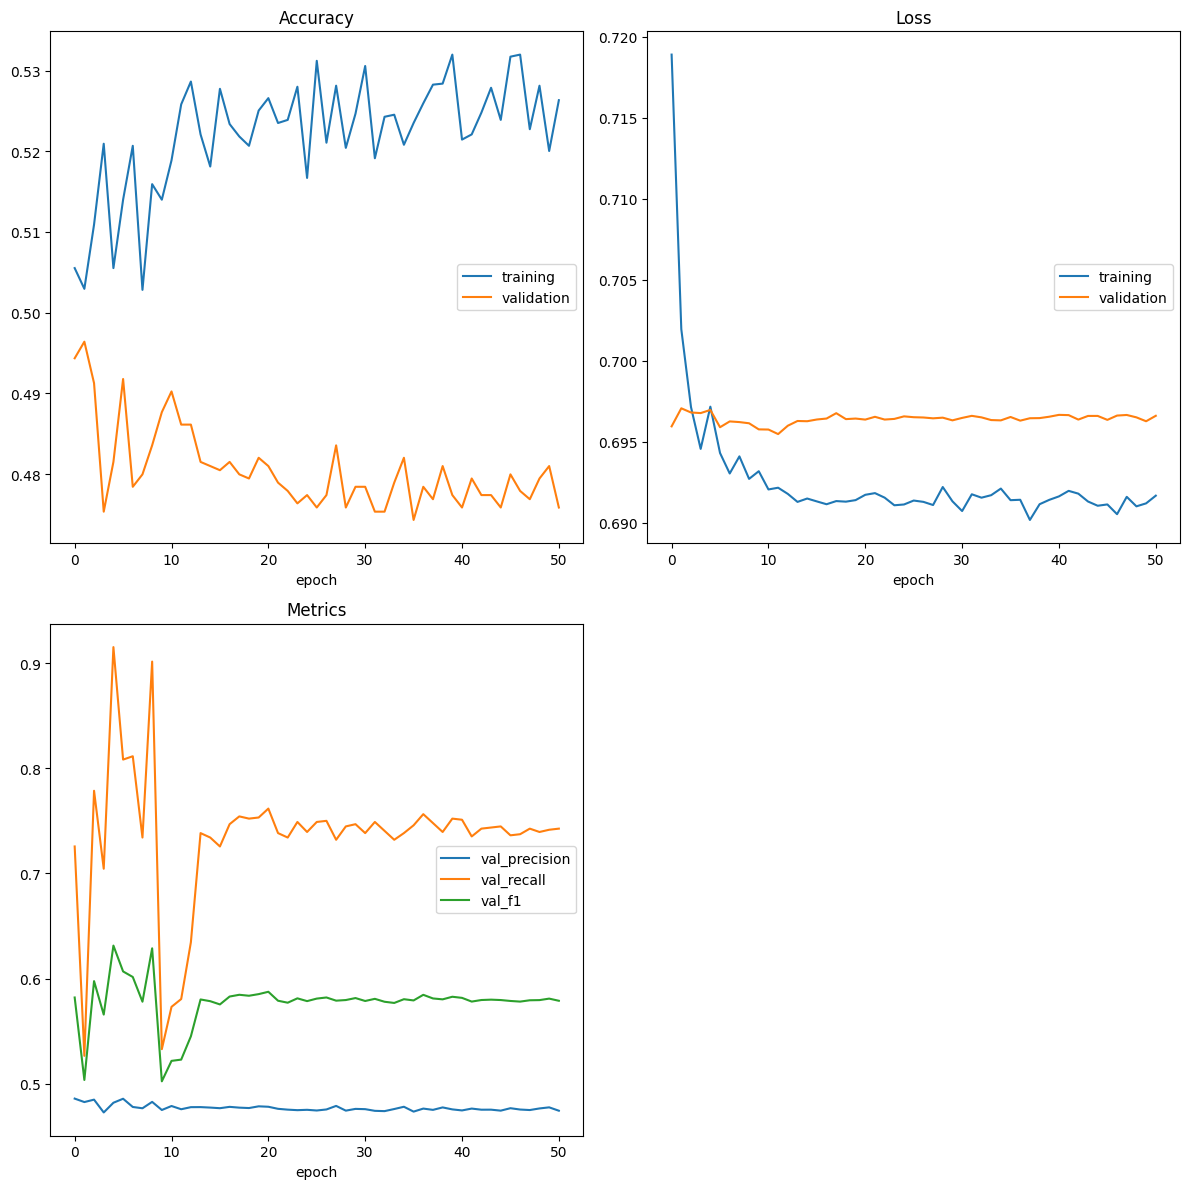

Epoch 51/100, Train Loss: 0.6917, Train Accuracy: 0.5263, Validation Loss: 0.6966, Validation Accuracy: 0.4758
No improvement for 50 epochs.
Stopping training due to no improvement.
Finished Training


In [26]:
epochs = 100
best_val_loss = float('inf')
no_improvement_epochs = 0
max_no_improvement_epochs = 50
min_improvement = 0.001

for epoch in range(epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, targets in trainloader:
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed precision training
            outputs = model(features)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_val_targets = []
    all_val_predictions = []

    with torch.no_grad():
        for features, targets in valloader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_val_targets.extend(targets.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss = val_loss / len(valloader.dataset)
    val_accuracy = correct / total

    # Calculate additional metrics
    val_precision = precision_score(all_val_targets, all_val_predictions, average='binary')
    val_recall = recall_score(all_val_targets, all_val_predictions, average='binary')
    val_f1 = f1_score(all_val_targets, all_val_predictions, average='binary')

    # Log the values
    logs['loss'] = train_loss
    logs['acc'] = train_accuracy
    logs['val_loss'] = val_loss
    logs['val_acc'] = val_accuracy
    logs['val_precision'] = val_precision
    logs['val_recall'] = val_recall
    logs['val_f1'] = val_f1

    # Send the logs to livelossplot
    liveloss.update(logs)
    liveloss.send()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check for improvement
    if val_loss < best_val_loss - min_improvement:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_epochs += 1

    print(f"No improvement for {no_improvement_epochs} epochs.")

    if no_improvement_epochs >= max_no_improvement_epochs:
        print("Stopping training due to no improvement.")
        break

    if train_accuracy >= 0.9999:
        print("Training accuracy reached near 100%. Stopping training.")
        break

    # Step the scheduler
    scheduler.step()

print('Finished Training')

In [27]:
# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
print('Model saved to final_model.pth')


Model saved to final_model.pth


In [28]:
# Testing loop to evaluate the model on the S&P 500 data

# Load the best model
model.load_state_dict(torch.load('final_model.pth'))

model.eval()
test_loss = 0.0
correct = 0
total = 0

all_test_targets = []
all_test_predictions = []

with torch.no_grad():
    for features, targets in testloader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        all_test_targets.extend(targets.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

test_loss = test_loss / len(testloader.dataset)
test_accuracy = correct / total

# Calculate additional metrics for the test set
test_precision = precision_score(all_test_targets, all_test_predictions, average='binary')
test_recall = recall_score(all_test_targets, all_test_predictions, average='binary')
test_f1 = f1_score(all_test_targets, all_test_predictions, average='binary')

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")


Test Loss: 0.6906, Test Accuracy: 0.5352
Test Precision: 0.5370, Test Recall: 0.9457, Test F1 Score: 0.6850
